In [1]:
import scanpy as sc
from pathlib import Path
import pandas as pd
import os
import re
import numpy as np
import anndata as ad
from tqdm import tqdm
import squidpy as sq
from jax.config import config

config.update("jax_enable_x64", True)

from joblib import Parallel, delayed
import squidpy as sq
import scanpy as sc
from anndata import AnnData
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2
%load_ext lab_black

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")

In [2]:
from pathlib import Path

path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/DataUpload")
dataset = 14
seed = 42
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
rng = np.random.default_rng(seed)
if "highly_variable" in adata_sp.var.columns:
    adata_sp = adata_sp[:, adata_sp.var.highly_variable].copy()
    n_genes = 100
else:
    n_genes = 10

# adata_sp_a = sc.pp.subsample(adata_sp, fraction=0.5, copy=True, random_state=seed)
# adata_sp_a = adata_sp.copy()
# adata_sp_b = adata_sp[~np.in1d(adata_sp.obs_names, adata_sp_a.obs_names)].copy()
adata_sp_b = adata_sp.copy()
sc_count = pd.read_csv(
    path_read / f"Dataset{dataset}" / "scRNA_count.txt", sep="\t", header=0, index_col=0
).T
adata_sp_a = AnnData(csr_matrix(sc_count.to_numpy()), dtype=sc_count.to_numpy().dtype)
adata_sp_a.var_names = sc_count.columns.tolist()
sc.pp.filter_cells(adata_sp_a, min_counts=10)
sc.pp.filter_genes(adata_sp_a, min_counts=2)
adata_sp_a.layers["counts"] = adata_sp_a.X.copy()
if adata_sp_a.shape[1] > 5000:
    sc.pp.highly_variable_genes(
        adata_sp_a, flavor="seurat_v3", n_top_genes=2000, subset=True
    )
sc.pp.normalize_total(adata_sp_a)
sc.pp.log1p(adata_sp_a)

intersect_var = list(set(adata_sp_a.var_names).intersection(set(adata_sp_b.var_names)))

# adata_sp_a = adata_sp_a[:, intersect_var].copy()
adata_sp_b = adata_sp_b[:, intersect_var].copy()

test_var = rng.choice(adata_sp_b.var_names, n_genes, replace=False).tolist() + ["eve"]
train_var = adata_sp_b.var_names[~np.in1d(adata_sp_b.var_names, test_var)].tolist()
true_df = sc.get.obs_df(adata_sp_b, keys=test_var)

# adata_sp_a_train = adata_sp_a[:, train_var].copy()
adata_sp_b_train = adata_sp_b[:, train_var].copy()

sc.tl.pca(adata_sp_b_train)
sc.tl.pca(adata_sp_a)
# adata_sp_a.obsm["X_pca"] = adata_sp_a_train.obsm["X_pca"].copy()

In [3]:
# intersect_var

In [4]:
# sc_count.columns.tolist()

In [5]:
adata_sc = adata_sp_a
adata_sp_train = adata_sp_b_train

In [6]:
params = {"epsilon": 1e-2, "alpha": 0.5}
epsilon, alpha = params["epsilon"], params["alpha"]

In [30]:
from moscot.problems.space import MappingProblem

prob = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp_train)
prob = prob.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"},
    sp_attr={"attr": "obsm", "key": "spatial"},
    var_names=adata_sp_train.var_names.values,
    callback="local-pca" if adata_sp_train.shape[1] > 100 else None,
    kwargs={"joint-space": True},
)

In [31]:
print(
    prob.problems[("src", "tgt")].xy.data.shape,
    prob.problems[("src", "tgt")].xy.data_y.shape,
)

(3039, 71) (1297, 71)


In [32]:
params = {"epsilon": 5e-2, "alpha": 0.5}
epsilon, alpha = params["epsilon"], params["alpha"]

In [33]:
prob = prob.solve(
    alpha=alpha,
    epsilon=epsilon,
    max_iterations=10_000,  # tau_a=1., tau_b=1.
)
print(prob.solutions[list(prob.solutions.keys())[0]].converged)
print(prob.solutions[list(prob.solutions.keys())[0]].cost)

True
1.7791291612857754


In [34]:
adata_pred = prob.impute(var_names=true_df.columns.tolist(), device="cpu")
pred_df = sc.get.obs_df(adata_pred, keys=true_df.columns.tolist())

In [35]:
corr_pearson = pred_df.corrwith(true_df, method="pearson")
corr_spearman = pred_df.corrwith(true_df, method="spearman")

In [36]:
out = pd.concat([corr_pearson, corr_spearman], axis=1)
out.columns = ["pearson", "spearman"]

In [37]:
out.max(0)

pearson     0.835933
spearman    0.663192
dtype: float64

In [38]:
out.mean(0)

pearson     0.493955
spearman    0.416612
dtype: float64

In [39]:
out

,pearson,spearman
prd,0.337294,0.328734
peb,0.595099,0.350046
bun,0.079843,0.235454
rau,0.698817,0.470985
hb,0.443445,0.362843
kni,0.348328,0.318284
Btk29A,0.527868,0.579698
knrl,0.831169,0.533436
E(spl)m5-HLH,0.072115,0.087463
htl,0.835933,0.652601


In [40]:
adata_sp.var_names

Index(['aay', 'Ama', 'Ance', 'Antp', 'apt', 'Blimp-1', 'bmm', 'bowl', 'brk',
       'Btk29A', 'bun', 'cad', 'CenG1A', 'CG10479', 'CG11208', 'CG14427',
       'CG17724', 'CG17786', 'CG43394', 'CG8147', 'cnc', 'croc', 'Cyp310a1',
       'D', 'dan', 'danr', 'Dfd', 'disco', 'Doc2', 'Doc3', 'dpn', 'edl', 'ems',
       'erm', 'Esp', 'E(spl)m5-HLH', 'eve', 'exex', 'fj', 'fkh', 'ftz', 'gk',
       'gt', 'h', 'hb', 'hkb', 'htl', 'Ilp4', 'ImpE2', 'ImpL2', 'ken', 'kni',
       'knrl', 'Kr', 'lok', 'Mdr49', 'Mes2', 'MESR3', 'mfas', 'Nek2', 'NetA',
       'noc', 'nub', 'numb', 'oc', 'odd', 'peb', 'prd', 'pxb', 'rau', 'rho',
       'run', 'sna', 'srp', 'tkv', 'tll', 'toc', 'Traf4', 'trn', 'tsh', 'twi',
       'zen', 'zen2', 'zfh1'],
      dtype='object')

In [41]:
adata_pred.obsm["spatial"] = adata_sp_b.obsm["spatial"].copy()

In [42]:
adata_sp.obsm["spatial "] = adata_sp.obsm["spatial"][:, [0, 2]]
adata_pred.obsm["spatial "] = adata_pred.obsm["spatial"][:, [0, 2]]

In [43]:
adata_pred.var_names

Index(['prd', 'peb', 'bun', 'rau', 'hb', 'kni', 'Btk29A', 'knrl',
       'E(spl)m5-HLH', 'htl', 'eve'],
      dtype='object')

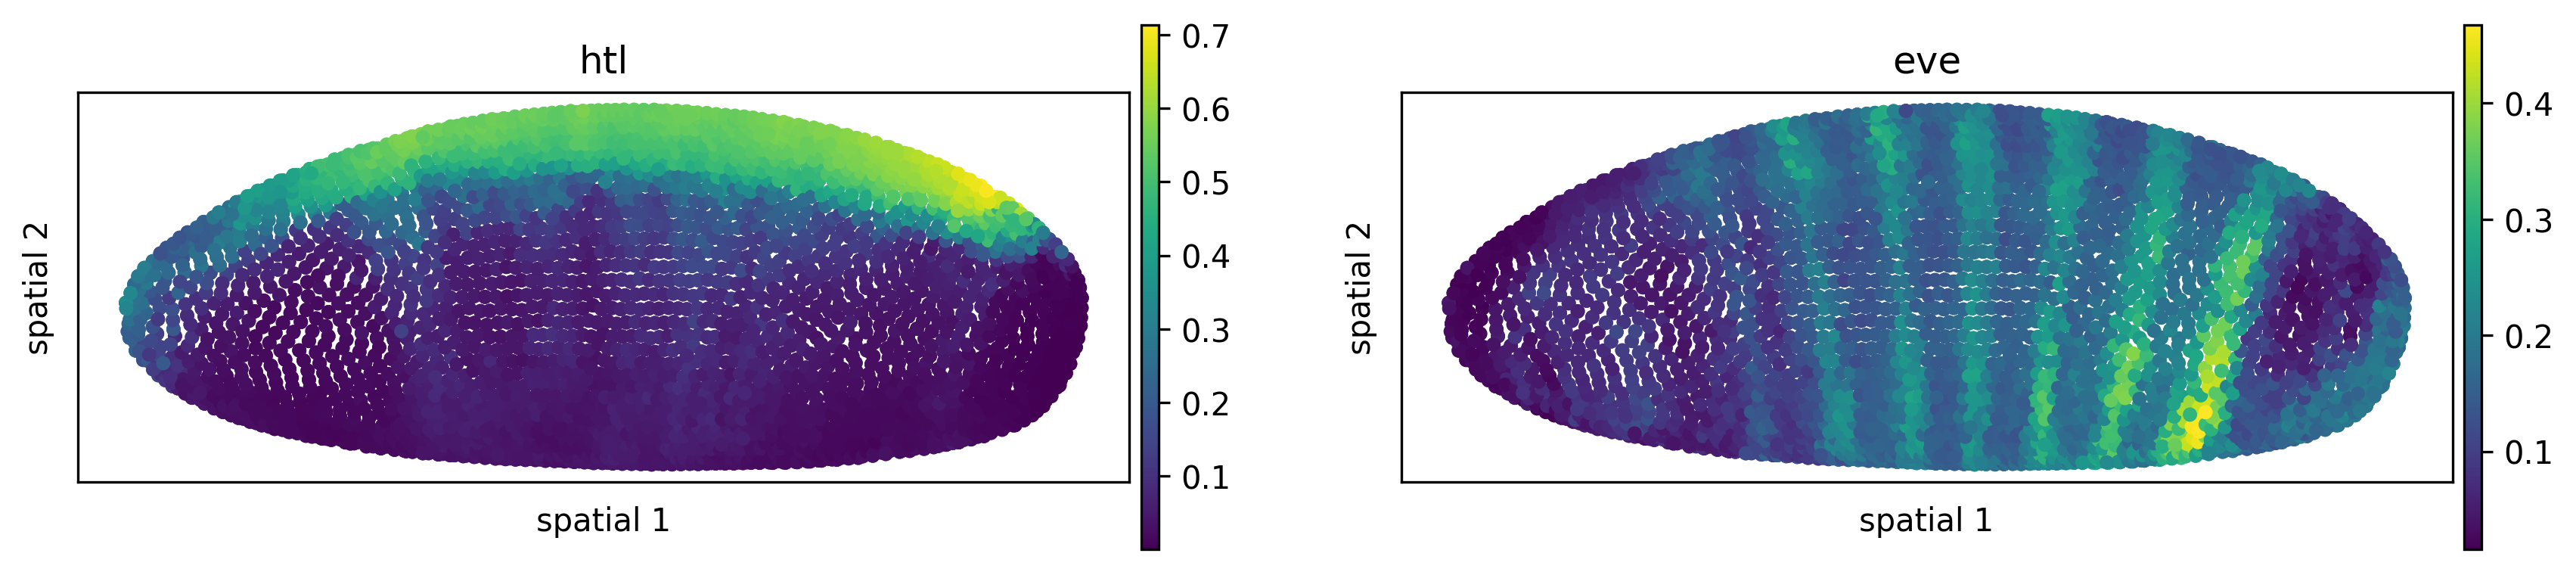

In [49]:
sq.pl.spatial_scatter(
    adata_pred,
    spatial_key="spatial ",
    color=["htl", "eve"],
    shape=None,
    size=50,
    dpi=300,
    figsize=(6, 3),
)

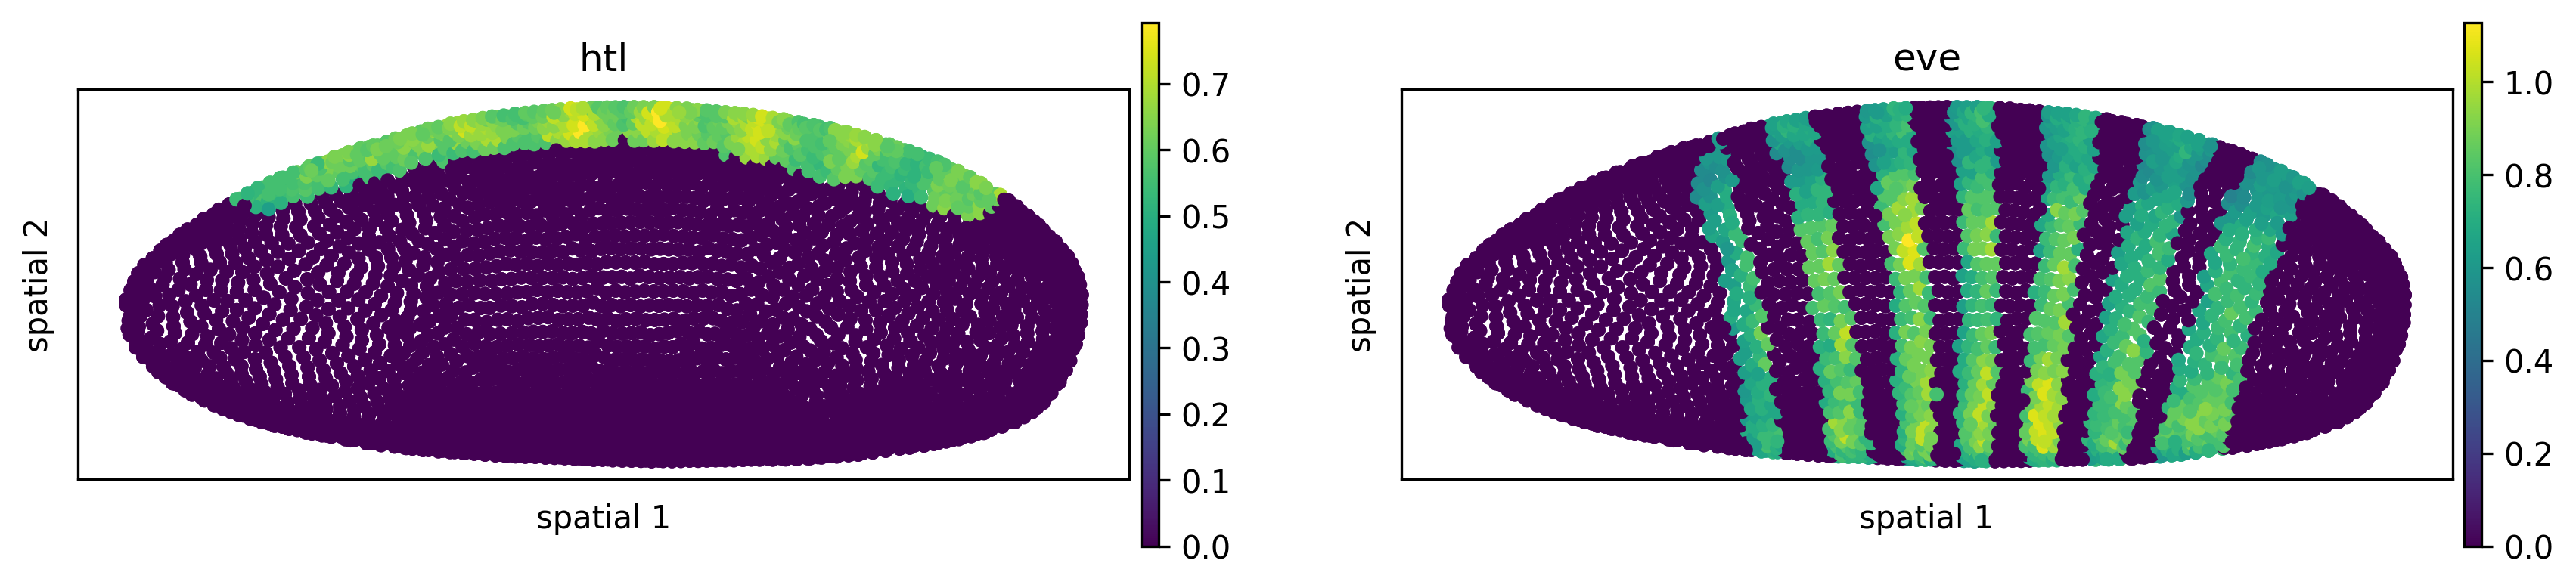

In [50]:
sq.pl.spatial_scatter(
    adata_sp,
    spatial_key="spatial ",
    color=["htl", "eve"],
    shape=None,
    size=50,
    dpi=300,
    figsize=(6, 3),
)

In [150]:
# sq.pl.spatial_scatter(adata_sp_b, color=["Esyt2"], shape=None)